In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from PIL import Image, ExifTags, UnidentifiedImageError
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
root_folder = "/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_mendeley"

labels = []
file_paths = []
i = 0
# Traverse through the root folder
for tree_folder in os.listdir(root_folder):
    tree_path = os.path.join(root_folder, tree_folder)

    # Check if it's a directory
    if os.path.isdir(tree_path):
        for file in os.listdir(tree_path):
            file_path = os.path.join(tree_path, file)
            
            # Check if the file is an image and can be opened
            try:
                with Image.open(file_path) as img:
                    # If the image can be opened, add it to the lists
                    labels.append(tree_folder)
                    file_paths.append(file_path)
            except (IOError, UnidentifiedImageError):
                # If the image cannot be opened, remove the file
                print(f"Removing damaged file: {file_path}")
                os.remove(file_path)
    i += 1
# Create a DataFrame
df = pd.DataFrame({"label": labels, "path": file_paths})

# Display the DataFrame
print(df)

                     label                                               path
0                 Wrightia  /kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...
1                 Wrightia  /kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...
2                 Wrightia  /kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...
3                 Wrightia  /kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...
4                 Wrightia  /kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...
...                    ...                                                ...
5573  Citrus aurantiifolia  /kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...
5574  Citrus aurantiifolia  /kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...
5575  Citrus aurantiifolia  /kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...
5576  Citrus aurantiifolia  /kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...
5577  Citrus aurantiifolia  /kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...

[5578 rows x 2 columns]


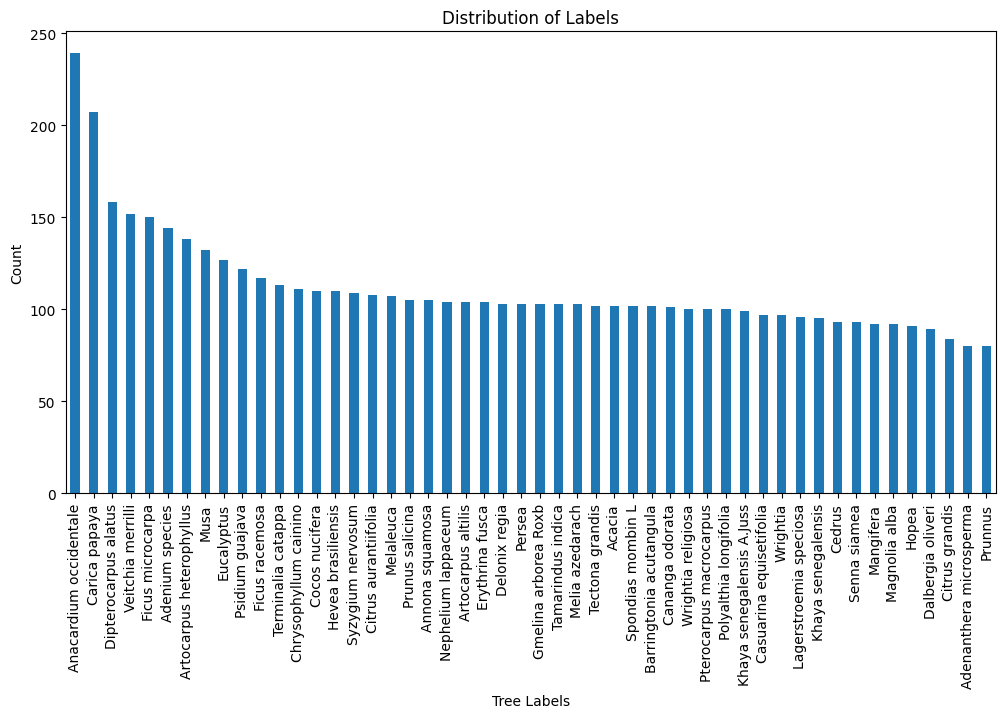

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# Assuming your DataFrame is named df

# Count the occurrences of each label
label_counts = df['label'].value_counts()
# Plot the distribution
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Tree Labels')
plt.ylabel('Count')
plt.show()

In [4]:
print(df['label'].unique())
print(len(df['label'].unique()))

['Wrightia' 'Wrightia religiosa' 'Tamarindus indica'
 'Lagerstroemia speciosa' 'Khaya senegalensis' 'Casuarina equisetifolia'
 'Erythrina fusca' 'Melaleuca' 'Dipterocarpus alatus' 'Artocarpus altilis'
 'Prunnus' 'Veitchia merrilli' 'Adenium species' 'Anacardium occidentale'
 'Polyalthia longifolia' 'Ficus microcarpa' 'Melia azedarach'
 'Spondias mombin L' 'Cananga odorata' 'Artocarpus heterophyllus'
 'Gmelina arborea Roxb' 'Hevea brasiliensis' 'Dalbergia oliveri'
 'Barringtonia acutangula' 'Syzygium nervosum' 'Persea' 'Carica papaya'
 'Chrysophyllum cainino' 'Musa' 'Magnolia alba' 'Eucalyptus' 'Mangifera'
 'Prunus salicina' 'Cedrus' 'Khaya senegalensis A.Juss' 'Ficus racemosa'
 'Psidium guajava' 'Nephelium lappaceum' 'Tectona grandis'
 'Pterocarpus macrocarpus' 'Delonix regia' 'Annona squamosa'
 'Terminalia catappa' 'Cocos nucifera' 'Citrus grandis'
 'Adenanthera microsperma' 'Acacia' 'Hopea' 'Senna siamea'
 'Citrus aurantiifolia']
50


In [5]:
# EXIF 데이터를 통해 이미지 방향을 수정하는 함수
def correct_image_orientation(img):
    try:
        exif = img._getexif()
        if exif is not None:
            for orientation_tag, orientation_value in ExifTags.TAGS.items():
                if orientation_value == 'Orientation':
                    orientation = exif.get(orientation_tag)
                    if orientation == 3:
                        img = img.rotate(180, expand=True)
                    elif orientation == 6:
                        img = img.rotate(270, expand=True)
                    elif orientation == 8:
                        img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError, TypeError):
        # EXIF 데이터가 없거나, 태그를 찾을 수 없거나, 이미지 포맷이 EXIF를 지원하지 않는 경우
        pass
    return img

In [6]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [7]:
df

,label,path,label_encoded
0,Wrightia,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,48
1,Wrightia,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,48
2,Wrightia,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,48
3,Wrightia,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,48
4,Wrightia,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,48
...,...,...,...
5573,Citrus aurantiifolia,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,13
5574,Citrus aurantiifolia,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,13
5575,Citrus aurantiifolia,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,13
5576,Citrus aurantiifolia,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,13


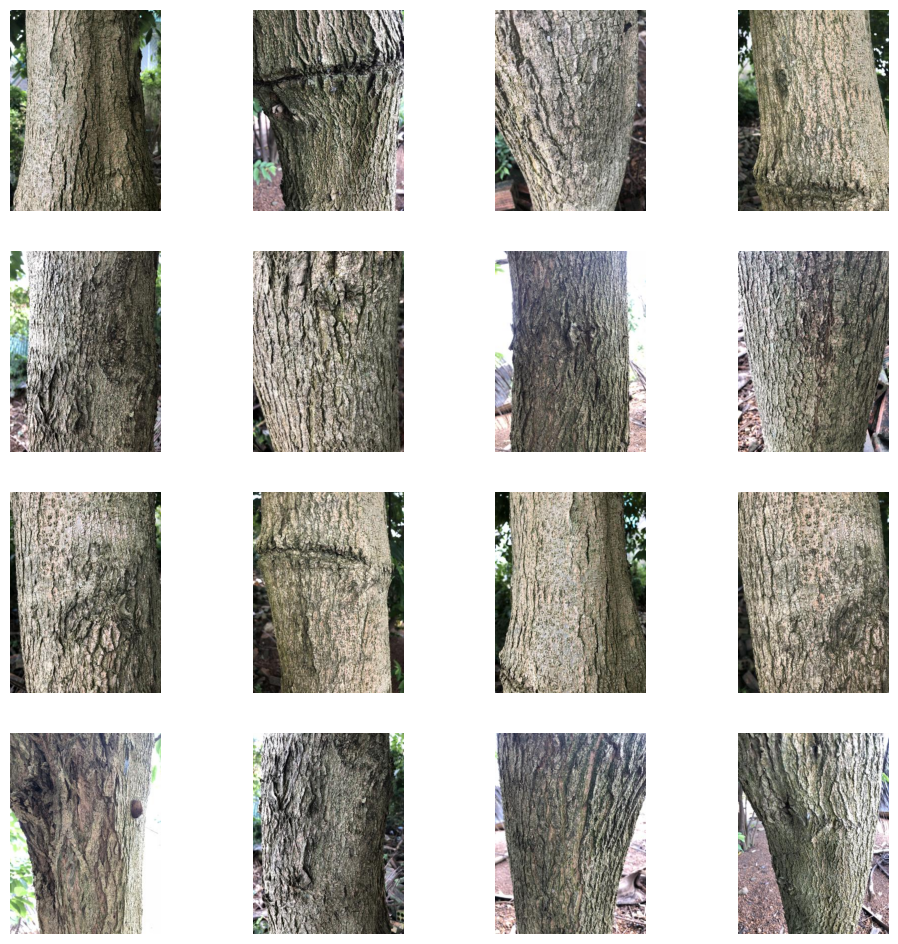

In [8]:
# 이미지 파일 경로들
image_paths = df['path'][:16]

# 이미지를 4x4 격자로 출력
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    # 이미지 불러오기
    img_path = image_paths[i]
    img = Image.open(img_path)

    # 이미지 출력
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [9]:
train_ratio = 0.7
test_ratio = 0.15
valid_ratio = 0.15

train, test_valid = train_test_split(df, test_size=(test_ratio + valid_ratio), random_state=42, stratify=df['label_encoded'])
test, valid = train_test_split(test_valid, test_size=valid_ratio/(test_ratio + valid_ratio), random_state=42, stratify=test_valid['label_encoded'])

train = train.drop(columns=['label'])
test = test.drop(columns=['label'])
valid = valid.drop(columns=['label'])

In [10]:
train

,path,label_encoded
3173,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,9
489,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,26
5286,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,25
2291,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,6
4806,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,46
...,...,...
1688,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,36
4639,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,17
585,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,10
4618,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,17


In [11]:
BATCH_SIZE = 16

class TreeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        out = dict()
        img_path = self.dataframe['path'].iloc[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        image = image.clone().detach().requires_grad_(True).to(torch.float)
        label = torch.tensor(self.dataframe['label_encoded'].iloc[idx], dtype=torch.long)
        
        return image, label


transform = transforms.Compose([
    transforms.CenterCrop((180,180)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=target_mean, std=target_std),
])

flip_transform = transforms.Compose([
    transforms.CenterCrop((180,180)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

bright_transform = transforms.Compose([
    transforms.CenterCrop((180,180)),
    transforms.Resize((224, 224)),              
    transforms.ColorJitter(brightness=(0.5, 0.9),),
    transforms.ToTensor()
])

In [12]:
pyramid_folder = './pyramid'
os.makedirs(pyramid_folder, exist_ok=True)  # 폴더가 없으면 생성

In [13]:
def create_image_pyramid(img_path, pyramid_folder, levels=3):
    img = Image.open(img_path)
    pyramid = [img_path]  # 원본 이미지 포함

    for level in range(1, levels):
        img_resized = img.resize((img.width // 2**level, img.height // 2**level), Image.ANTIALIAS)
        
        # 원본 파일명과 확장자 분리
        base_name = os.path.basename(img_path)
        name, ext = os.path.splitext(base_name)
        
        # 새 파일명 생성
        resized_path = os.path.join(pyramid_folder, f"{name}_pyramid_{level}{ext}")
        img_resized.save(resized_path)
        pyramid.append(resized_path)

    return pyramid


In [14]:
extended_data = []
for _, row in df.iterrows():
    pyramid_paths = create_image_pyramid(row['path'], pyramid_folder)
    for path in pyramid_paths:
        extended_data.append({'path': path, 'label_encoded': row['label_encoded']})

extended_df = pd.DataFrame(extended_data)


/tmp/ipykernel_42/3886435974.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((img.width // 2**level, img.height // 2**level), Image.ANTIALIAS)


In [15]:
train = extended_df
train

,path,label_encoded
0,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,48
1,./pyramid/IMG_3762_pyramid_1.JPG,48
2,./pyramid/IMG_3762_pyramid_2.JPG,48
3,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,48
4,./pyramid/IMG_3717_pyramid_1.JPG,48
...,...,...
16729,./pyramid/IMG_5705_pyramid_1.JPG,13
16730,./pyramid/IMG_5705_pyramid_2.JPG,13
16731,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,13
16732,./pyramid/IMG_5682_pyramid_1.JPG,13


In [16]:
# 원하는 원본 이미지 파일명
original_image_name = 'IMG_3762'

# 해당 원본 이미지의 피라미드 이미지들을 필터링
pyramid_images = train[train['path'].str.contains(original_image_name)]

# 결과 출력
pyramid_images

,path,label_encoded
0,/kaggle/input/barkvn50/BarkVN-50/BarkVN-50_men...,48
1,./pyramid/IMG_3762_pyramid_1.JPG,48
2,./pyramid/IMG_3762_pyramid_2.JPG,48


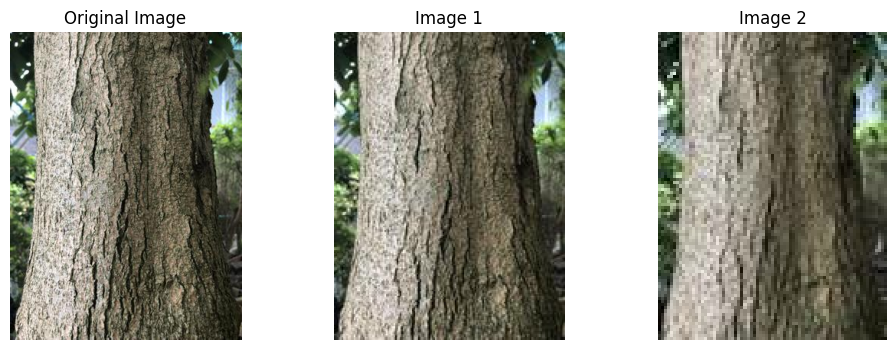

In [17]:
plt.figure(figsize=(16, 4))

for i, img_path in enumerate(pyramid_images['path'], 1):
    img = Image.open(img_path)
    plt.subplot(1, 4, i)
    plt.imshow(img)
    if i == 1:
        plt.title(f"Original Image")
    else:
        plt.title(f"Image {i-1}")
    plt.axis('off')

plt.show()

In [18]:
train_dataset = TreeDataset(dataframe=train, transform=transform)
flip_dataset = TreeDataset(dataframe=train, transform=flip_transform)
bright_dataset = TreeDataset(dataframe=train, transform=bright_transform)
train_dataset = train_dataset + flip_dataset + bright_dataset

test_dataset = TreeDataset(dataframe=test, transform=transform)
valid_dataset = TreeDataset(dataframe=valid, transform=transform)
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

50202
837
837


In [19]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

3138
53
53


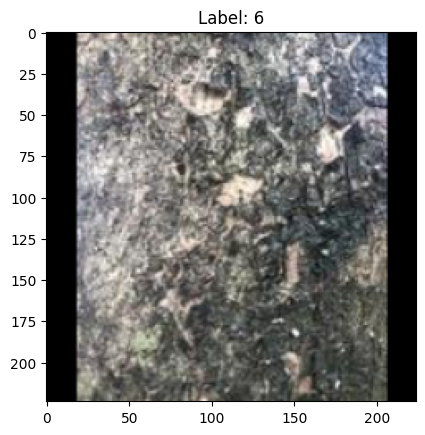

In [20]:
for images, labels in train_loader:
    
    # 이미지를 시각화하기 위해 배치에서 이미지 하나를 선택
    img = images[0].detach().cpu().permute(1, 2, 0).numpy()  # 채널 순서 변경 및 NumPy 배열로 변환
    # print(img)
    # print(img.shape)
    
    # 이미지 시각화
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()
    
    break  # 첫 번째 배치만 시각화

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
num_classes = len(df['label_encoded'].unique())
model = models.convnext_small(pretrained=True).to(device)

# 파라미터 고정
for param in model.parameters():
    param.requires_grad = False

# 마지막 분류기 레이어 교체
model.classifier[2] = nn.Linear(768, num_classes).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:00<00:00, 299MB/s] 


In [26]:
# model = models.resnet50(pretrained=True).to(device)
# num_classes = len(df['label_encoded'].unique())

# for param in model.parameters():
#     param.requires_grad = False

# model.fc = nn.Sequential(
#     nn.Linear(2048, 128),
#     nn.ReLU(inplace = True),
#     nn.Linear(128, num_classes)).to(device)



In [ ]:
# 손실 함수와 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 30
best_val_accuracy = 0.0  # 최고의 검증 정확도를 저장하기 위한 변수

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', position=0, leave=True):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Training Loss: {average_loss}')

    # Validation
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = total_correct / total_samples
        average_val_loss = total_val_loss / len(valid_loader)
        print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {accuracy * 100:.2f}%')

        # 최고의 검증 정확도일 때 모델 저장
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            torch.save(model.state_dict(), 'best_tree_cropped_classifier.pth')
            print('Best model saved.')

# 전체 학습이 끝난 후 최고의 모델을 저장했습니다.

Epoch 1/30: 100%|██████████| 3138/3138 [24:08<00:00,  2.17it/s]


Training Loss: 1.2318623353619724
Validation Loss: 0.4551093039928742, Validation Accuracy: 90.44%
Best model saved.


Epoch 2/30: 100%|██████████| 3138/3138 [24:12<00:00,  2.16it/s]


Training Loss: 0.7433694449744268
Validation Loss: 0.32743987841707356, Validation Accuracy: 92.35%
Best model saved.


Epoch 3/30: 100%|██████████| 3138/3138 [24:11<00:00,  2.16it/s]


Training Loss: 0.6510592793168499
Validation Loss: 0.2620822473095273, Validation Accuracy: 93.07%
Best model saved.


Epoch 4/30: 100%|██████████| 3138/3138 [24:09<00:00,  2.17it/s]


Training Loss: 0.6048365218672899
Validation Loss: 0.1948028472515772, Validation Accuracy: 95.82%
Best model saved.


Epoch 5/30: 100%|██████████| 3138/3138 [24:08<00:00,  2.17it/s]


Training Loss: 0.5708161203963522
Validation Loss: 0.1781099758040652, Validation Accuracy: 95.58%


Epoch 6/30: 100%|██████████| 3138/3138 [24:04<00:00,  2.17it/s]


Training Loss: 0.550039198268573
Validation Loss: 0.16730745489937518, Validation Accuracy: 96.30%
Best model saved.


Epoch 7/30: 100%|██████████| 3138/3138 [24:05<00:00,  2.17it/s]


Training Loss: 0.5349804303383869
Validation Loss: 0.13848446820915308, Validation Accuracy: 97.37%
Best model saved.


Epoch 8/30: 100%|██████████| 3138/3138 [24:04<00:00,  2.17it/s]


Training Loss: 0.518925406906571
Validation Loss: 0.13739610864025242, Validation Accuracy: 97.13%


Epoch 9/30: 100%|██████████| 3138/3138 [24:01<00:00,  2.18it/s]


Training Loss: 0.5079672754907814
Validation Loss: 0.12973101391404304, Validation Accuracy: 97.85%
Best model saved.


Epoch 10/30: 100%|██████████| 3138/3138 [23:59<00:00,  2.18it/s]


Training Loss: 0.49929929298210424
Validation Loss: 0.1239166415454644, Validation Accuracy: 97.25%


Epoch 11/30: 100%|██████████| 3138/3138 [23:59<00:00,  2.18it/s]


Training Loss: 0.4973719183740208
Validation Loss: 0.11092048191975029, Validation Accuracy: 97.97%
Best model saved.


Epoch 12/30: 100%|██████████| 3138/3138 [23:59<00:00,  2.18it/s]


Training Loss: 0.4851700808218377
Validation Loss: 0.09941107818399961, Validation Accuracy: 98.21%
Best model saved.


Epoch 13/30: 100%|██████████| 3138/3138 [24:07<00:00,  2.17it/s]


Training Loss: 0.4859071524702179
Validation Loss: 0.09559909577639598, Validation Accuracy: 98.09%


Epoch 14/30: 100%|██████████| 3138/3138 [24:05<00:00,  2.17it/s]


Training Loss: 0.47963700670104326
Validation Loss: 0.09113917512959747, Validation Accuracy: 97.97%


Epoch 15/30: 100%|██████████| 3138/3138 [24:06<00:00,  2.17it/s]


Training Loss: 0.4701981068540714
Validation Loss: 0.09664136115110146, Validation Accuracy: 97.73%


Epoch 16/30: 100%|██████████| 3138/3138 [24:04<00:00,  2.17it/s]


Training Loss: 0.47264512844260254
Validation Loss: 0.09273449747981329, Validation Accuracy: 98.21%


Epoch 17/30: 100%|██████████| 3138/3138 [24:06<00:00,  2.17it/s]


Training Loss: 0.46167075265866125
Validation Loss: 0.08615016462369207, Validation Accuracy: 98.33%
Best model saved.


Epoch 18/30: 100%|██████████| 3138/3138 [24:01<00:00,  2.18it/s]


Training Loss: 0.4653529060447744
Validation Loss: 0.08281955510413028, Validation Accuracy: 98.21%


Epoch 19/30: 100%|██████████| 3138/3138 [24:11<00:00,  2.16it/s]


Training Loss: 0.46025008610446766
Validation Loss: 0.07898694916435008, Validation Accuracy: 98.69%
Best model saved.


Epoch 20/30: 100%|██████████| 3138/3138 [24:10<00:00,  2.16it/s]


Training Loss: 0.46008155358643044
Validation Loss: 0.07295766494781622, Validation Accuracy: 99.04%
Best model saved.


Epoch 21/30: 100%|██████████| 3138/3138 [24:06<00:00,  2.17it/s]


Training Loss: 0.4561475489853654
Validation Loss: 0.07308245972150339, Validation Accuracy: 98.92%


Epoch 22/30: 100%|██████████| 3138/3138 [24:12<00:00,  2.16it/s]


Training Loss: 0.4510661794681166
Validation Loss: 0.08194310683757067, Validation Accuracy: 98.57%


Epoch 23/30: 100%|██████████| 3138/3138 [24:10<00:00,  2.16it/s]


Training Loss: 0.4521618722783671
Validation Loss: 0.06939934721032053, Validation Accuracy: 99.16%
Best model saved.


Epoch 24/30: 100%|██████████| 3138/3138 [24:11<00:00,  2.16it/s]


Training Loss: 0.44944756130947283
Validation Loss: 0.07068600068923156, Validation Accuracy: 98.81%


Epoch 25/30: 100%|██████████| 3138/3138 [24:09<00:00,  2.16it/s]


Training Loss: 0.45168643664963987
Validation Loss: 0.06976346145296153, Validation Accuracy: 98.69%


Epoch 26/30: 100%|██████████| 3138/3138 [24:08<00:00,  2.17it/s]


Training Loss: 0.44626621869460953
Validation Loss: 0.0680579222334584, Validation Accuracy: 98.57%


Epoch 27/30:  90%|█████████ | 2826/3138 [21:46<02:23,  2.18it/s]

## HUFS tree

In [ ]:
model.load_state_dict(torch.load('/kaggle/working/best_tree_cropped_classifier.pth'))
model.to(device)

In [ ]:
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
print(f'Test Accuracy: {accuracy * 100:.2f}%')